In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data


In [ ]:
import pandas as pd

# Replace with your actual folder path in Google Drive
folder_path = '/content/drive/MyDrive/MRP/dataset/'

# Load CSV files
train_df = pd.read_csv(folder_path + 'train_set.csv')
test_df = pd.read_csv(folder_path + 'test_set.csv')

# Separate features and labels
X_train = train_df.drop('Is Laundering', axis=1)
y_train = train_df['Is Laundering']

X_test = test_df.drop('Is Laundering', axis=1)
y_test = test_df['Is Laundering']


# Plot AUC ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the ROC curve and computes AUC for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict or predict_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - auc_value: Computed AUC value.
    """
    # Use predict_proba if available for better ROC results
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_value = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc_value

# Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the Precision-Recall (PR) curve and computes Average Precision (AP) score
    for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict_proba or decision_function method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - avg_precision: Computed Average Precision score.
    """
    # Get scores for the positive class
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model must have predict_proba or decision_function method.")

    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    # Plot the PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return avg_precision


# Save Model

In [ ]:
import pickle
import shutil
import os

def save_model(model,model_name, model_id, destination_dir=None):
    """
    Saves a model to a local file and optionally copies it to a destination directory.

    Parameters:
        model: The trained model object to save.
        model_id: An identifier to use in the filename (e.g., an integer or string).
        destination_dir: Optional; directory path to copy the model file to (e.g., Google Drive).

    Returns:
        model_filename (str): The name of the saved model file.
    """
    model_filename = f'{model_name}_model_{model_id}.pkl'

    # Save the model locally
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    # If a destination directory is provided, copy the file there
    if destination_dir:
        # Ensure the destination directory exists
        os.makedirs(destination_dir, exist_ok=True)
        shutil.copy(model_filename, os.path.join(destination_dir, model_filename))

    return model_filename

# save_model(best_model,model_name="Xgboost_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

#Precision Recall Vs Threshold

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(model, X_test, y_test):
    """
    Plots precision and recall against decision thresholds for a classification model.

    Parameters:
    - model: Trained classification model with a predict_proba method.
    - X_test: Feature set to predict on.
    - y_test: True labels for the test set.
    """
    # Get predicted probabilities for positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Remove the last value of precisions and recalls to match the size of thresholds
    precisions = precisions[:-1]
    recalls = recalls[:-1]

    # Plot precision and recall vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.title("Precision and Recall vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# plot_precision_recall_vs_threshold(best_model, X_test, y_test)

# Xgboost classifier

In [ ]:
# Define a function to train and evaluate an XGBoost model on uploaded AML data

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from datetime import datetime

def train_xgboost_aml_model( X_train,y_train,X_test,y_test,scale_pos_weight=100):
    """
    Trains an XGBoost classifier for Anti-Money Laundering detection.

    Parameters:

    - scale_pos_weight (int): Class imbalance adjustment for positive class (default is 100).

    Returns:
    - classification report as DataFrame
    - trained XGBoost model
    """

    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    t0 = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_time_secs = (datetime.now() - t0).seconds

    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, model,training_time_secs


In [ ]:
report_df, model, training_time= train_xgboost_aml_model( X_train,y_train,X_test,y_test,scale_pos_weight=100)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
training_time_secs

,precision,recall,f1-score,support
0,0.999604,0.987280,0.993404,1.521951e+06
1,0.047153,0.616871,0.087609,1.553000e+03
accuracy,0.986903,0.986903,0.986903,9.869026e-01
macro avg,0.523378,0.802075,0.540506,1.523504e+06
weighted avg,0.998633,0.986903,0.992481,1.523504e+06


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the ROC curve and computes AUC for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict or predict_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - auc_value: Computed AUC value.
    """
    # Use predict_proba if available for better ROC results
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_value = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc_value


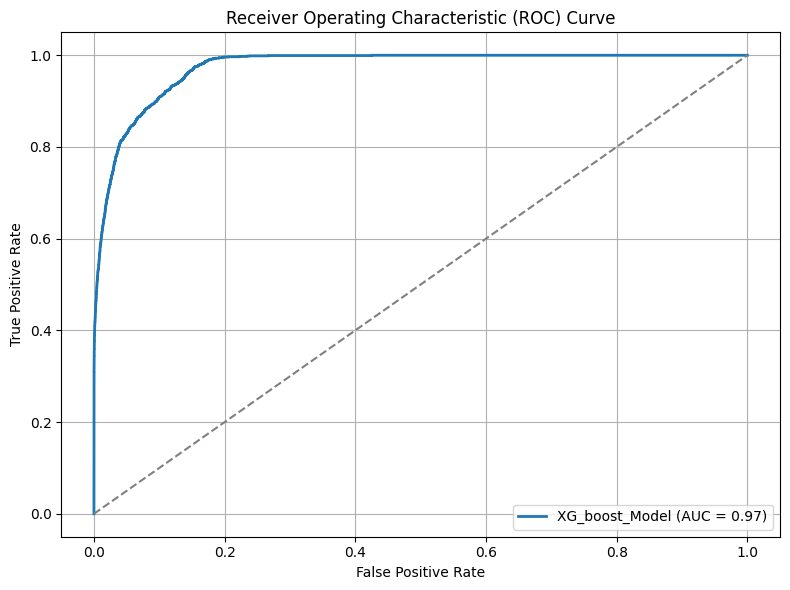

np.float64(0.974085614462028)

In [ ]:
plot_roc_curve(model, X_test, y_test, model_name='XG_boost_Model')

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the Precision-Recall (PR) curve and computes Average Precision (AP) score
    for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict_proba or decision_function method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - avg_precision: Computed Average Precision score.
    """
    # Get scores for the positive class
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model must have predict_proba or decision_function method.")

    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    # Plot the PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return avg_precision


# Optimal threshold

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_optimal_threshold(model, X_test, y_test):
    """
    Calculates the optimal threshold for classification based on the highest F1 score.

    Parameters:
    - model: A trained classifier with a `predict_proba` method
    - X_test: Feature set for testing
    - y_test: True labels for testing

    Returns:
    - optimal_threshold: The threshold that yields the highest F1 score
    - precision: Precision at the optimal threshold
    - recall: Recall at the optimal threshold
    - f1: F1 score at the optimal threshold
    """
    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Compute F1 scores and find the best threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_index = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_index]

    precision = precisions[best_index]
    recall = recalls[best_index]
    f1 = f1_scores[best_index]

    print(f"Best Threshold: {optimal_threshold:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    return optimal_threshold, precision, recall, f1

# threshold, precision, recall, f1 = find_optimal_threshold(best_model, X_test, y_test)



Best Threshold: 0.83
Precision: 0.73, Recall: 0.32, F1: 0.44


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


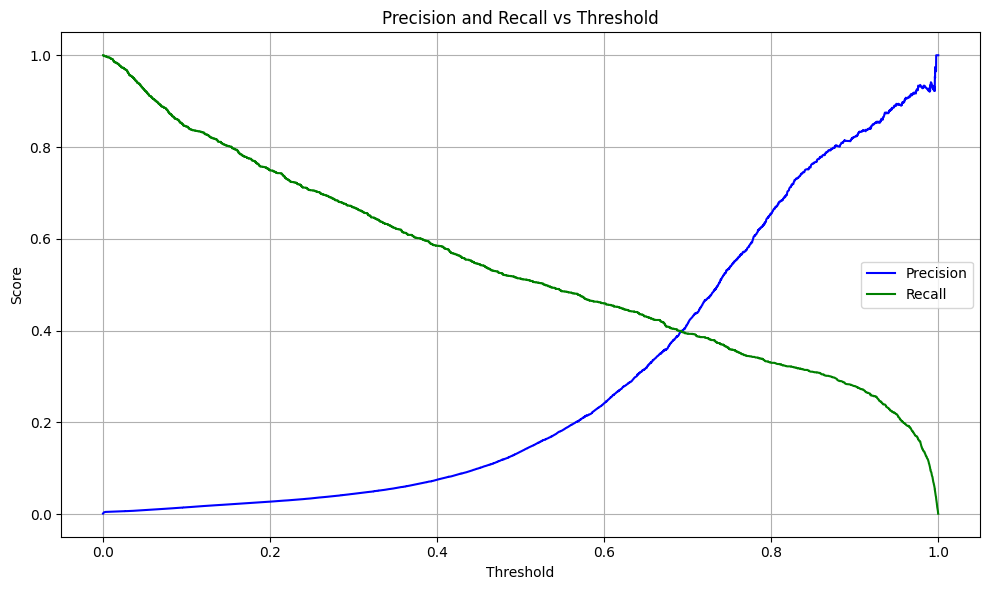

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(model, X_test, y_test):
    """
    Plots precision and recall against decision thresholds for a classification model.

    Parameters:
    - model: Trained classification model with a predict_proba method.
    - X_test: Feature set to predict on.
    - y_test: True labels for the test set.
    """
    # Get predicted probabilities for positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Remove the last value of precisions and recalls to match the size of thresholds
    precisions = precisions[:-1]
    recalls = recalls[:-1]

    # Plot precision and recall vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.title("Precision and Recall vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_precision_recall_vs_threshold(best_model, X_test, y_test)


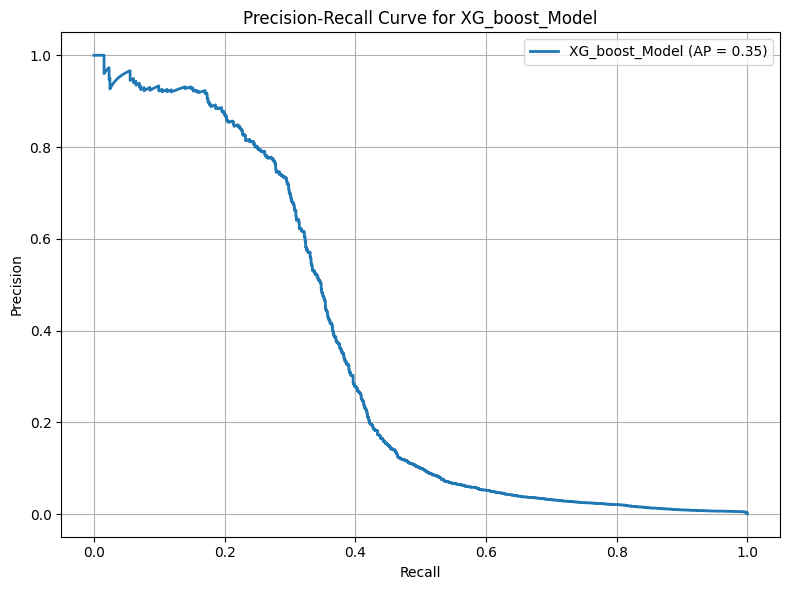

np.float64(0.34668395877386643)

In [ ]:
plot_precision_recall_curve(model, X_test, y_test, model_name='XG_boost_Model')

# Hyperparameter Tuning Xgboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import pandas as pd
import xgboost as xgb



def tune_xgboost_hyperparameters(X_train, y_train, X_test, y_test, n_iter=10, random_state=42):
    """
    Performs hyperparameter tuning on an XGBoost classifier using RandomizedSearchCV.

    Parameters:
    - X_train, y_train: Training features and labels
    - X_test, y_test: Testing features and labels
    - n_iter (int): Number of parameter settings sampled (default: 10)
    - random_state (int): Seed for reproducibility

    Returns:
    - report_df: DataFrame of the classification report for the best model
    - best_model: The best XGBoost model after tuning
    - best_params: Dictionary of the best hyperparameters
    """

    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'scale_pos_weight': [50, 75, 100, 150]
    }

    xgb_clf = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state
    )
    t0 = datetime.now()
    rand_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )

    t0 = datetime.now()
    rand_search.fit(X_train, y_train)
    training_time_secs = (datetime.now() - t0).seconds
    best_model = rand_search.best_estimator_
    best_params = rand_search.best_params_

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, best_model, best_params, training_time_secs


In [ ]:
report_df, best_model, best_params, training_time_secs=tune_xgboost_hyperparameters(X_train, y_train, X_test, y_test, n_iter=10, random_state=42)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
print("Best Hyperparameters:\n",best_params)
print("report_df:\n",report_df)
print("training_time_secs\n",training_time_secs)


Best Hyperparameters:
 {'colsample_bytree': np.float64(0.8473544037332349), 'learning_rate': np.float64(0.12473859738014881), 'max_depth': 6, 'n_estimators': 113, 'scale_pos_weight': 50, 'subsample': np.float64(0.6185801650879991)}
report_df:
               precision    recall  f1-score       support
0              0.999501  0.996680  0.998089  1.521951e+06
1              0.136092  0.512556  0.215077  1.553000e+03
accuracy       0.996186  0.996186  0.996186  9.961864e-01
macro avg      0.567796  0.754618  0.606583  1.523504e+06
weighted avg   0.998621  0.996186  0.997290  1.523504e+06
training_time_secs
 889


In [ ]:
import pickle
import shutil
import os

def save_model(model,model_name, model_id, destination_dir=None):
    """
    Saves a model to a local file and optionally copies it to a destination directory.

    Parameters:
        model: The trained model object to save.
        model_id: An identifier to use in the filename (e.g., an integer or string).
        destination_dir: Optional; directory path to copy the model file to (e.g., Google Drive).

    Returns:
        model_filename (str): The name of the saved model file.
    """
    model_filename = f'{model_name}_model_{model_id}.pkl'

    # Save the model locally
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    # If a destination directory is provided, copy the file there
    if destination_dir:
        # Ensure the destination directory exists
        os.makedirs(destination_dir, exist_ok=True)
        shutil.copy(model_filename, os.path.join(destination_dir, model_filename))

    return model_filename

save_model(best_model,model_name="Xgboost_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

'Xgboost_tuned_model_1.pkl'

In [ ]:
import joblib

model = joblib.load("/content/drive/MyDrive/MRP/model/Xgboost_tuned_model_1.pkl")

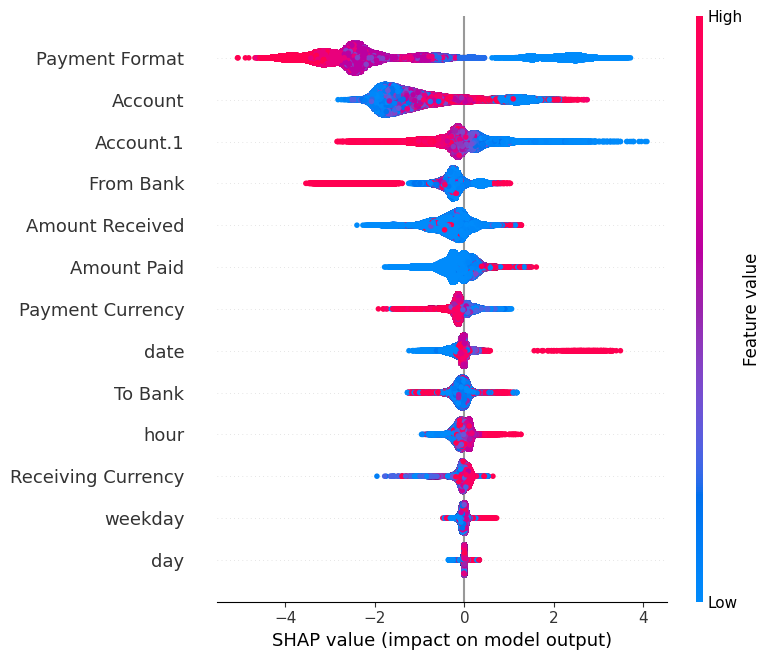

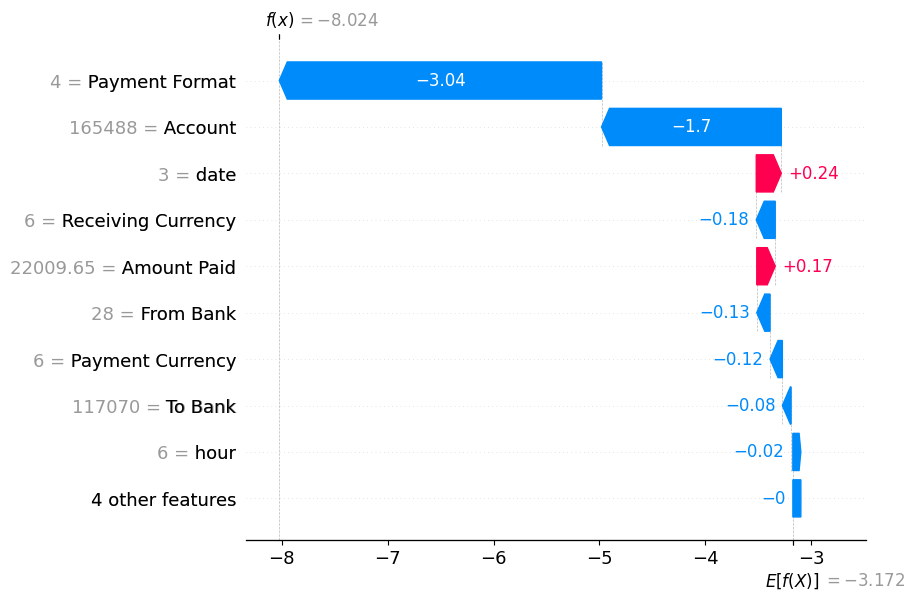

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Global summary
shap.summary_plot(shap_values, X_test)

# Local explanation for one sample
shap.plots.waterfall(shap_values[0])

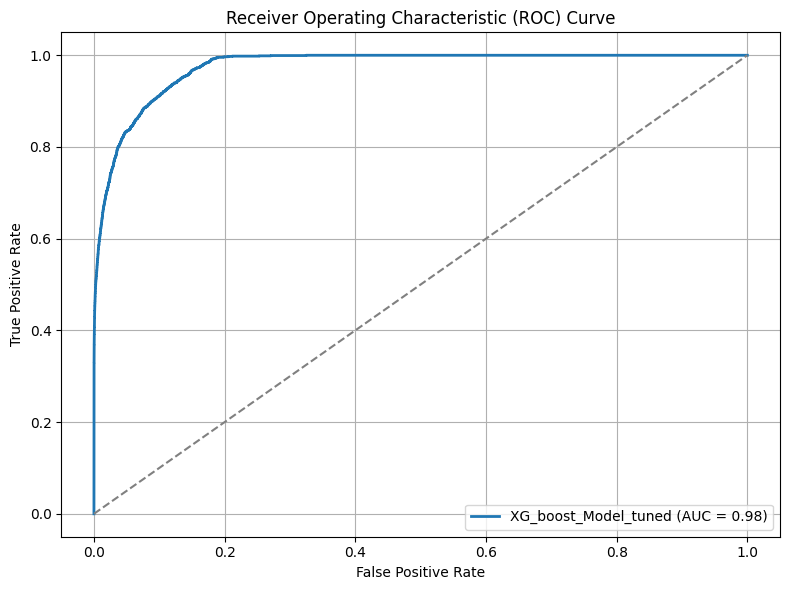

np.float64(0.9752614777099088)

In [ ]:
plot_roc_curve(best_model, X_test, y_test, model_name='XG_boost_Model_tuned')

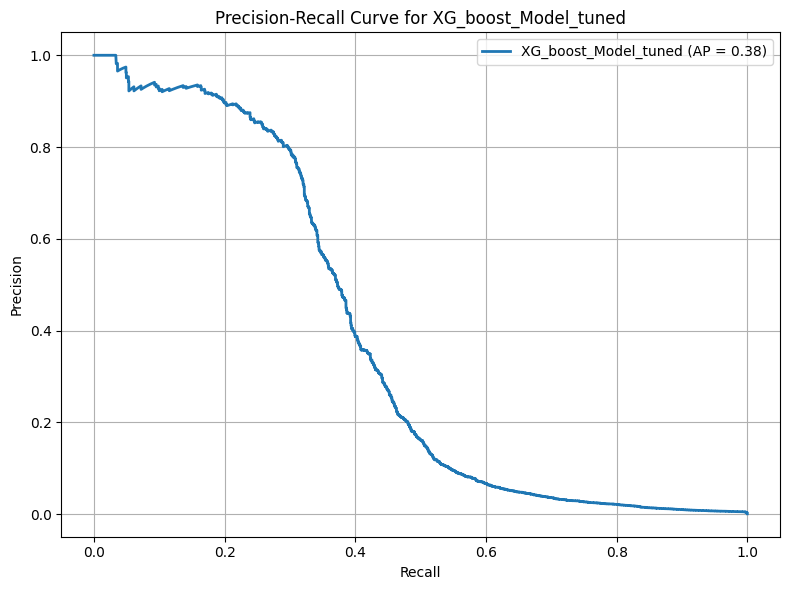

np.float64(0.3797488764995604)

In [ ]:
plot_precision_recall_curve(best_model, X_test, y_test, model_name='XG_boost_Model_tuned')

# SMOTE Xgboost

In [ ]:
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.metrics import classification_report
import pandas as pd
import xgboost as xgb

def train_xgboost_aml_model_with_smote(X_train, y_train, X_test, y_test, scale_pos_weight=100):
    """
    Trains an XGBoost classifier for Anti-Money Laundering detection using SMOTE for class balancing.

    Parameters:
    - X_train, y_train: Training data (imbalanced)
    - X_test, y_test: Testing data (left untouched for realistic evaluation)
    - scale_pos_weight (int): Class imbalance adjustment for XGBoost (default is 100)

    Returns:
    - classification report as DataFrame
    - trained XGBoost model
    - training time in seconds
    """

    # Apply SMOTE to the training data
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    t0 = datetime.now()
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    training_time_secs = (datetime.now() - t0).seconds

    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, model, training_time_secs



In [ ]:
report_df, model, training_time_secs= train_xgboost_aml_model_with_smote(X_train, y_train, X_test, y_test, scale_pos_weight=100)
report_df


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,precision,recall,f1-score,support
0,0.999921,0.848677,0.918112,1.521951e+06
1,0.006261,0.934321,0.012438,1.553000e+03
accuracy,0.848764,0.848764,0.848764,8.487644e-01
macro avg,0.503091,0.891499,0.465275,1.523504e+06
weighted avg,0.998908,0.848764,0.917189,1.523504e+06


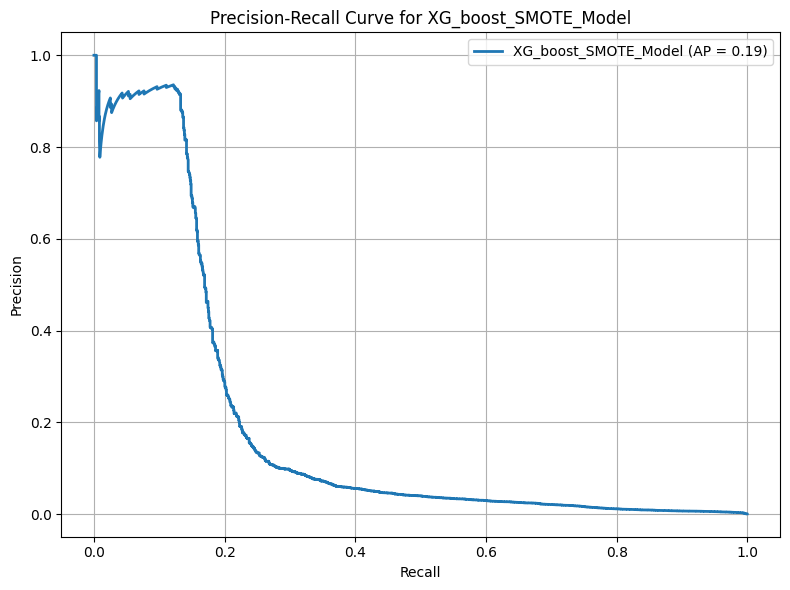

np.float64(0.19470303968731575)

In [ ]:
plot_precision_recall_curve(model, X_test, y_test, model_name='XG_boost_SMOTE_Model')

# SMOTE + Hyperparameter Tuning

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import xgboost as xgb
from datetime import datetime

def train_xgboost_aml_with_smote_and_tuning(X_train, y_train, X_test, y_test, n_iter=20, cv=3, random_state=42):
    """
    Applies SMOTE and tunes XGBoost hyperparameters using RandomizedSearchCV.

    Parameters:
    - X_train, y_train: Training data
    - X_test, y_test: Testing data
    - n_iter: Number of parameter combinations to try
    - cv: Cross-validation folds
    - random_state: Reproducibility

    Returns:
    - best classification report
    - best estimator (model)
    - training time in seconds
    - best hyperparameters found
    """

    # Define SMOTE + XGBoost pipeline
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=random_state)),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state))
    ])

    # Define hyperparameter grid
    param_grid = {
        'xgb__n_estimators': [100, 200, 300],
        'xgb__max_depth': [4, 6, 8],
        'xgb__learning_rate': [0.01, 0.1, 0.2],
        'xgb__scale_pos_weight': [1, 10, 50, 100],
        'xgb__subsample': [0.7, 0.8, 1.0],
        'xgb__colsample_bytree': [0.7, 0.8, 1.0]
    }

    # Initialize randomized search
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring='f1',
        verbose=1,
        n_jobs=-1,
        random_state=random_state
    )

    t0 = datetime.now()
    search.fit(X_train, y_train)
    training_time_secs = (datetime.now() - t0).seconds

    # Predict on untouched test set
    y_pred = search.best_estimator_.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, search.best_estimator_, training_time_secs, search.best_params_


In [ ]:
# report_df, best_model, best_params, training_time_secs=tune_xgboost_hyperparameters(X_train, y_train, X_test, y_test, n_iter=10, random_state=42)
report_df, best_model, best_params, training_time_secs= train_xgboost_aml_with_smote_and_tuning(X_train, y_train, X_test, y_test, n_iter=20, cv=3, random_state=42)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("Best Hyperparameters:\n",best_params)
print("report_df:\n",report_df)
print("training_time_secs\n",training_time_secs)

Best Hyperparameters:
 7135
report_df:
               precision    recall  f1-score       support
0              0.999579  0.988745  0.994132  1.521951e+06
1              0.050917  0.591758  0.093766  1.553000e+03
accuracy       0.988340  0.988340  0.988340  9.883400e-01
macro avg      0.525248  0.790251  0.543949  1.523504e+06
weighted avg   0.998612  0.988340  0.993214  1.523504e+06
training_time_secs
 {'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.7}


In [ ]:
save_model(best_model,model_name="Xgboost_SMOTE_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

'Xgboost_SMOTE_tuned_model_1.pkl'

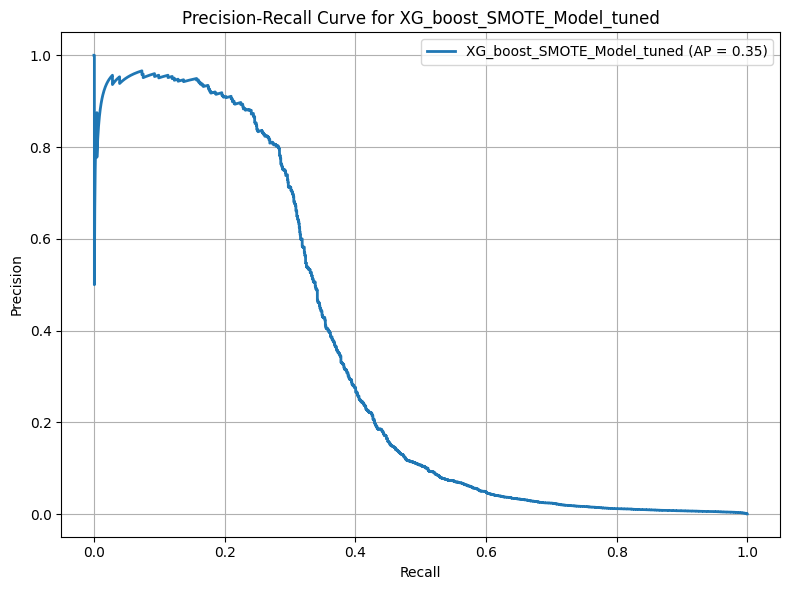

np.float64(0.348893881958894)

In [ ]:
plot_precision_recall_curve(best_model, X_test, y_test, model_name='XG_boost_SMOTE_Model_tuned')

/tmp/ipython-input-6-4291847198.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


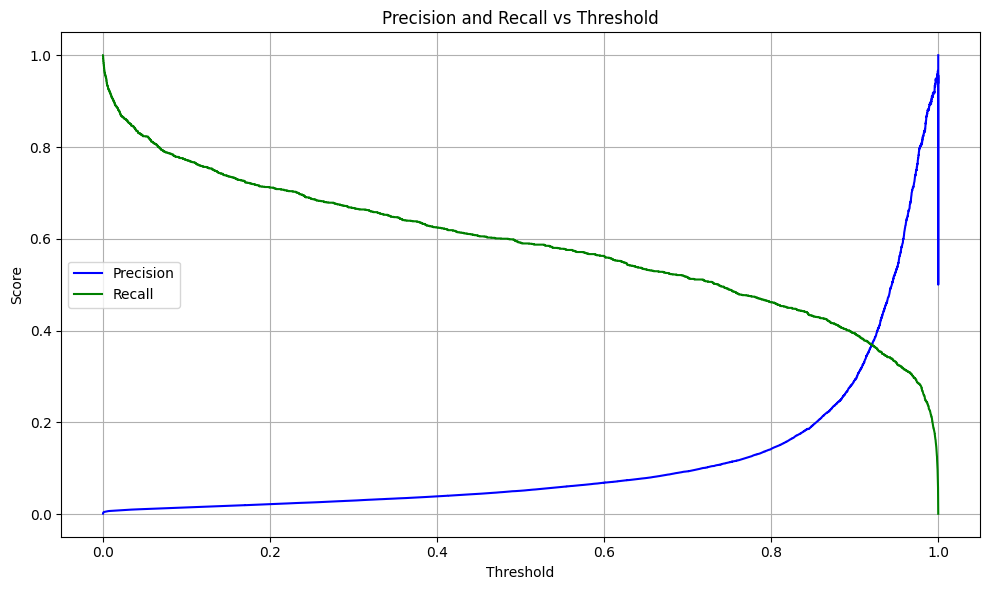

In [ ]:
plot_precision_recall_vs_threshold(best_model, X_test, y_test)